# Simple Policy Optimization
Notebook for trying out the tooling involved in using policy gradient methods to train a model on CarRacing.

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import gym
import matplotlib.pyplot as plt
import numpy as np
tfd = tfp.distributions
%matplotlib inline

In [3]:
# Edge TPU for embedding extraction
from edgetpu.basic import basic_engine

In [4]:
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1
# !pip install gym[box2d]

In [5]:
model_path = os.path.join(
    os.environ.get('HOME'), 'Work', 'ExternCode', 'edgetpu_models',
    'mobilenet_v1_1.0_224_quant_embedding_extractor_edgetpu.tflite')

In [6]:
tf.__version__

'2.1.0'

In [7]:
tf.executing_eagerly()

True

In [8]:
tfp.__version__

'0.9.0'

# Create Car Racing environment 

In [9]:
env_name = 'CarRacing-v0' # 'SpaceInvaders-v0'
env = gym.make(env_name)

In [10]:
env.observation_space

Box(96, 96, 3)

In [11]:
env.action_space

Box(3,)

Track generation: 1087..1371 -> 284-tiles track


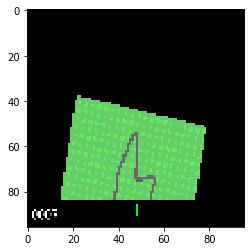

In [12]:
_ = plt.imshow(env.reset())

In [13]:
env.action_space.low, env.action_space.high

(array([-1.,  0.,  0.], dtype=float32), array([1., 1., 1.], dtype=float32))

In [14]:
# Sampling from action space randomly
# tfd.Multinomial(total_count=1, logits=[-1.] * env.action_space.n).sample(1)
env.action_space.sample()

array([0.21740156, 0.82393134, 0.6710421 ], dtype=float32)

# Next step: create sequence of frames  
We can implement sequence of frames by allocating an initial n_frame x h x w x n_channel buffer tensor and concatenate each new frame onto buffer, removing the previous last element.

In [15]:
n_row_col = 2
n_frame = n_row_col**2  # Square number for tiling
buffer = tf.zeros((n_frame,) + env.observation_space.shape, dtype=tf.uint8)

In [16]:
buffer.shape

TensorShape([4, 96, 96, 3])

In [17]:
# Update buffer by putting new frame at front, removing last frame in buffer
for i in range(100):
    obs, reward, done, info = env.step(env.action_space.sample())
    updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
    buffer = updated_buffer

# Processing multiple frames as a single image
Idea to try out: use a pre-trained image classification network such as MobileNet for embedding vector extraction and use this as input to the reinforcement learning algorithm.  This is also an excuse to play with my [coral.ai USB accelerator](https://coral.ai/docs/accelerator/get-started/). 

To do this we need to turn the `n_frame x h x w x c` tensor into a `(n x h) x (n x h) x c` image displaying multiple frames at the same time, where `n**2 = n_frame`.

In [18]:
def seq_to_img(seq, n):
    res = []
    for i in range(n):
        res.append(tf.concat([seq[i*n + j, ...] for j in range(n)], axis=1))
    return tf.concat(res, axis=0)

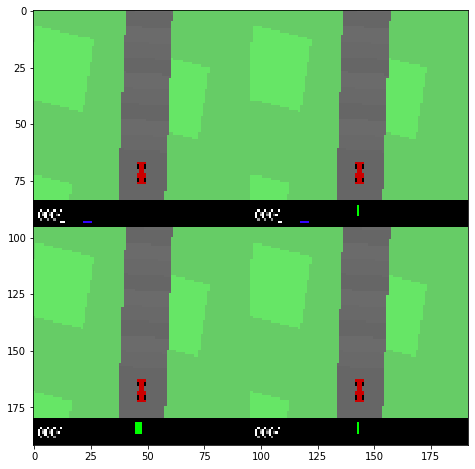

In [19]:
fig = plt.figure(figsize=(12,8))
# _ = plt.imshow(tf.reshape(tf.transpose(buffer, perm=[3, 2, 1, 0]), (2*96, 2*96, -1)))
_ = plt.imshow(seq_to_img(buffer, n_row_col))
ax = plt.gca()
# ax.axis('equal')
ax.set_aspect('equal', 'box')
# fig.savefig('test.png')

# Extract embedding
Use the MobileNet v1 model running on EdgeTPU to convert the set of n_frame frames represented as a single image into a 1024 element feature vector

In [20]:
engine = basic_engine.BasicEngine(model_path=model_path)

In [21]:
engine.get_all_output_tensors_sizes()

array([1024], dtype=int32)

In [22]:
_, img_ht, img_wd, _ = engine.get_input_tensor_shape()

In [23]:
buff_resized = tf.image.resize(seq_to_img(buffer, n_row_col), (img_ht, img_wd), method='nearest').numpy()

In [24]:
buff_resized.shape

(224, 224, 3)

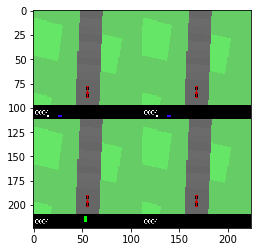

In [25]:
_ = plt.imshow(buff_resized)

In [26]:
_, _ = engine.run_inference(buff_resized.flatten()) # First run is slower, ignore
time_ms, embedding = engine.run_inference(buff_resized.flatten())
print(f'Time taken to extract embedding: {time_ms:.2f}ms')

Time taken to extract embedding: 4.76ms


In [27]:
embedding

array([4.5174675 , 0.        , 0.02352848, ..., 0.494098  , 0.        ,
       0.        ], dtype=float32)

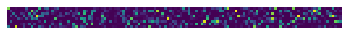

In [28]:
_ = plt.imshow(embedding.reshape(8, -1))
_ = plt.gca().axis('off')

In [29]:
embedding.shape

(1024,)

# Define the policy network
Now that we have a simple observation space to work with we can look at creating a policy network from it.
Our action space is 3D \[0., 1.\] unit cube (-1.,-1 for first dimension) which suggests we could sample each action dimension from a Beta distribution. The Beta distribution is defined by two non-negative parameters a and b so a simple policy network can be created by using a single fully connected layer with exponential activation function.

In [30]:
inputs = tf.keras.layers.Input(shape=(1024, ))
fc = tf.keras.layers.Dense(
    6, activation='exponential',  kernel_initializer='zeros',
    bias_initializer='zeros'
)(inputs)
unscaled_actions = tfp.layers.DistributionLambda(
    lambda x: tfd.Beta(x[...,:3], x[..., 3:], name='unscaled')
)(fc)
# Shift and scale: subtract min, scale by range, add min
shift_b1 = tfp.bijectors.Shift(env.action_space.low, name='shift_1')
scale_b = tfp.bijectors.Scale(env.action_space.high - env.action_space.low, name='scale')
shift_b2 = tfp.bijectors.Shift(-env.action_space.low, name='shift_2')
# Transform the individual Beta distributions to get correct output ranges
# and also combine into single event using tfd.Independent
scaled_actions = tfp.layers.DistributionLambda(
    lambda x: tfd.Independent(
        tfd.TransformedDistribution(
            distribution=x,
            bijector=tfp.bijectors.Chain([shift_b2, scale_b, shift_b1]),
            name='shift_scale'
        ),
        reinterpreted_batch_ndims=None,
        name='independent'
    ))(unscaled_actions)

network = tf.keras.Model(inputs, scaled_actions)

In [31]:
network.build(input_shape=(1024, ))

In [32]:
network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
_________________________________________________________________
distribution_lambda (Distrib ((None, 3), (None, 3))    0         
_________________________________________________________________
distribution_lambda_1 (Distr ((None, 3), (None, 3))    0         
Total params: 6,150
Trainable params: 6,150
Non-trainable params: 0
_________________________________________________________________


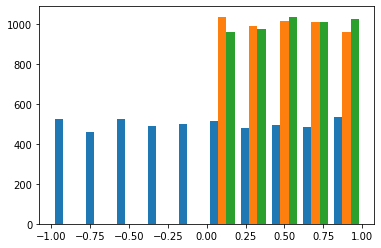

In [33]:
# Can sample from policy 
_ = plt.hist(network(embedding.reshape((1,-1))).sample(5000).numpy().reshape((-1, 3)))

In [34]:
# Output of the policy is a probability distribution
next_action = network(embedding.reshape((1,-1)))

In [35]:
# Can get the probability of an action
next_action.log_prob([0., 0., 0.])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.6931472], dtype=float32)>

In [36]:
# Can generate an action
next_action.sample()[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.4740162,  0.3473378,  0.8450126], dtype=float32)>

# Reinforcement Learning
Start with the [Policy Gradient example](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) from SpinningUp at OpenAi.  Need to modify this to work with TensorFlow 2.1 by using tf.GradientTape in the training update, as well as reshaping data because of the representation chosen above.

Currently this doesn't train well but at least runs without (any obvious) errors.

In [37]:
# for training policy
def train_one_epoch():
    # MMcD Storing sequence of frames
    n_row_col = 2
    n_frame = n_row_col**2  # Square number for tiling
    buffer = tf.zeros((n_frame,) + env.observation_space.shape, dtype=tf.uint8)
    batch_size = 5000
        
    # make some empty lists for logging.
    batch_obs = []          # for observations
    batch_acts = []         # for actions
    batch_weights = []      # for R(tau) weighting in policy gradient
    batch_rets = []         # for measuring episode returns
    batch_lens = []         # for measuring episode lengths

    # reset episode-specific variables
    obs = env.reset()       # first obs comes from starting distribution
    done = False            # signal from environment that episode is over
    ep_rews = []            # list for rewards accrued throughout ep

    # render first episode of each epoch
    finished_rendering_this_epoch = False

    updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
    buffer = updated_buffer
    
    # MMcD Optimizer for update step
    adam = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    # collect experience by acting in the environment with current policy
    while True:

#         # rendering
#         if (not finished_rendering_this_epoch) and render:
#             env.render()

        buff_resized = tf.image.resize(
            seq_to_img(buffer, n_row_col), (img_ht, img_wd), method='nearest').numpy()
        time_ms, embedding = engine.run_inference(buff_resized.flatten())


        # save obs
        batch_obs.append(embedding.copy())

        
        # act in the environment
        act = network(embedding.reshape((1,-1))).sample()[0].numpy()
        # act = get_action(torch.as_tensor(obs, dtype=torch.float32))
        obs, rew, done, _ = env.step(act)

        updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
        buffer = updated_buffer
        
        # save action, reward
        batch_acts.append(act)
        ep_rews.append(rew)

        if done:
            # if episode is over, record info about episode
            ep_ret, ep_len = sum(ep_rews), len(ep_rews)
            batch_rets.append(ep_ret)
            batch_lens.append(ep_len)

            # the weight for each logprob(a|s) is R(tau)
            batch_weights += [ep_ret] * ep_len

            # reset episode-specific variables
            obs, done, ep_rews = env.reset(), False, []

            # won't render again this epoch
            finished_rendering_this_epoch = True

            # end experience loop if we have enough of it
            if len(batch_obs) > batch_size:
                break

    
    with tf.GradientTape() as tape:
        logp = network(
            tf.convert_to_tensor(batch_obs)).log_prob(tf.convert_to_tensor(batch_acts))
        batch_loss =  tf.reduce_mean(-(logp * tf.convert_to_tensor(batch_weights)))
        
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(batch_loss, network.trainable_weights)
    
        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        adam.apply_gradients(zip(grads, network.trainable_weights))
    
        
    return batch_loss, batch_rets, batch_lens

In [38]:
train_one_epoch()

Track generation: 1035..1298 -> 263-tiles track
Track generation: 977..1225 -> 248-tiles track
Track generation: 1187..1488 -> 301-tiles track
Track generation: 1279..1603 -> 324-tiles track
Track generation: 1040..1309 -> 269-tiles track
Track generation: 1011..1274 -> 263-tiles track
Track generation: 1276..1599 -> 323-tiles track


(<tf.Tensor: shape=(), dtype=float32, numpy=-20.545082>,
 [-27.480916030534782,
  -19.028340080971674,
  -36.66666666666721,
  -38.0804953560377,
  -29.104477611940606,
  -27.48091603053472],
 [1000, 1000, 1000, 1000, 1000, 1000])

In [39]:
# for i in range(50):
#     batch_loss_t, batch_rets_l, batch_lens = train_one_epoch()
#     batch_loss = batch_loss_t.numpy()
#     batch_rets = np.mean(batch_rets_l)
#     print(f'Loss: {batch_loss:.2f}  Reward: {batch_rets}')
    
#     # Can sample from policy 
#     _ = plt.hist(network(embedding.reshape((1,-1))).sample(5000).numpy().reshape((-1, 3)))
#     plt.show()

In [40]:
train_one_epoch()

Track generation: 1132..1419 -> 287-tiles track
Track generation: 1031..1293 -> 262-tiles track
Track generation: 1121..1406 -> 285-tiles track
Track generation: 1056..1324 -> 268-tiles track
Track generation: 1243..1558 -> 315-tiles track
Track generation: 1127..1413 -> 286-tiles track
Track generation: 1135..1423 -> 288-tiles track


(<tf.Tensor: shape=(), dtype=float32, numpy=-18.515984>,
 [-30.0699300699304,
  -19.540229885057467,
  -26.056338028169204,
  -25.093632958801535,
  -33.12101910828078,
  -29.824561403509115],
 [1000, 1000, 1000, 1000, 1000, 1000])

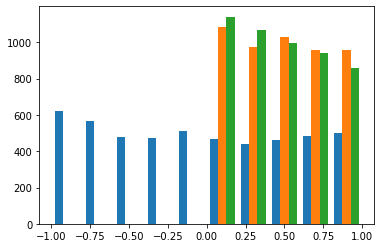

In [41]:
# Can sample from policy 
_ = plt.hist(network(embedding.reshape((1,-1))).sample(5000).numpy().reshape((-1, 3)))
plt.show()

In [42]:
# network.save_weights('car_racing_weights.h5')